In [13]:
import pandas as pd

# Load titanic dataset and create gender variable

titanic = pd.read_csv("titanic.csv")

titanic["Gender"] = titanic["Sex"].apply(lambda d: 1 if d == "female" else 0)

titanic.drop(["Name", "Sex"], axis = 1, inplace = True)

# Separate x and y

array = titanic.values
y = array[:,0]
X = array[0:,1:]

In [14]:
from xgboost import XGBClassifier
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\duart\AppData\Local\conda\conda\envs\testEnv\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [15]:
# Tune XGBoost

def tune(x,y):

    seed=7
    model = XGBClassifier()
    kfold=StratifiedKFold(n_splits=3, random_state=seed, shuffle = True)

    param_grid={"max_depth":[1,2,3,4,5,6,7,8,9,10], "n_estimators":[50,100,150,200,250,300]}
    
    grid=GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=kfold)
    grid_result=grid.fit(x,y)
    
    print(f'Grid Best Score {grid_result.best_score_:.7f} \
          Number of trees {grid_result.best_params_["n_estimators"]:3d} \
          Max Depth of Decision Trees {grid_result.best_params_["max_depth"]:3d}')
    print()
      
    means = grid_result.cv_results_["mean_test_score"]
    stds = grid_result.cv_results_["std_test_score"]      
    params = grid_result.cv_results_["params"] 
              
    tu_plot=pd.DataFrame(columns=["N estimators","Size of DT","accuracy"]) 
    
    for mean,std,param in zip(means,stds,params):
        print(f'N. estimators {param["n_estimators"]:3d} \
                Depth {param["max_depth"]:3d} accuracy {mean:.7f} ({std:.5f})')
        tu_plot=tu_plot.append({"N estimators":param["n_estimators"],\
                                "Size of DT":param["max_depth"], "accuracy":mean}, ignore_index=True)
        
    plt.figure(figsize=(15,9))
    sns.lineplot(data=tu_plot, x=tu_plot["N estimators"], y=tu_plot["accuracy"], \
                 hue=tu_plot["Size of DT"], legend="full", palette=sns.color_palette("bright") ,linewidth=2.5)
    plt.title("N. Estimators & Depth of the Decision Trees")
    plt.xlabel("N. Estimators")
    plt.ylabel("accuracy")

Grid Best Score 0.8297565           Number of trees  50           Max Depth of Decision Trees   8

N. estimators  50                 Depth   1 accuracy 0.7936899 (0.03179)
N. estimators 100                 Depth   1 accuracy 0.7959307 (0.02307)
N. estimators 150                 Depth   1 accuracy 0.8060773 (0.02571)
N. estimators 200                 Depth   1 accuracy 0.8060773 (0.02306)
N. estimators 250                 Depth   1 accuracy 0.8049511 (0.02418)
N. estimators 300                 Depth   1 accuracy 0.8094671 (0.02215)
N. estimators  50                 Depth   2 accuracy 0.8083410 (0.00177)
N. estimators 100                 Depth   2 accuracy 0.8207322 (0.01942)
N. estimators 150                 Depth   2 accuracy 0.8196175 (0.01242)
N. estimators 200                 Depth   2 accuracy 0.8162468 (0.02078)
N. estimators 250                 Depth   2 accuracy 0.8151092 (0.01935)
N. estimators 300                 Depth   2 accuracy 0.8184876 (0.02072)
N. estimators  50        

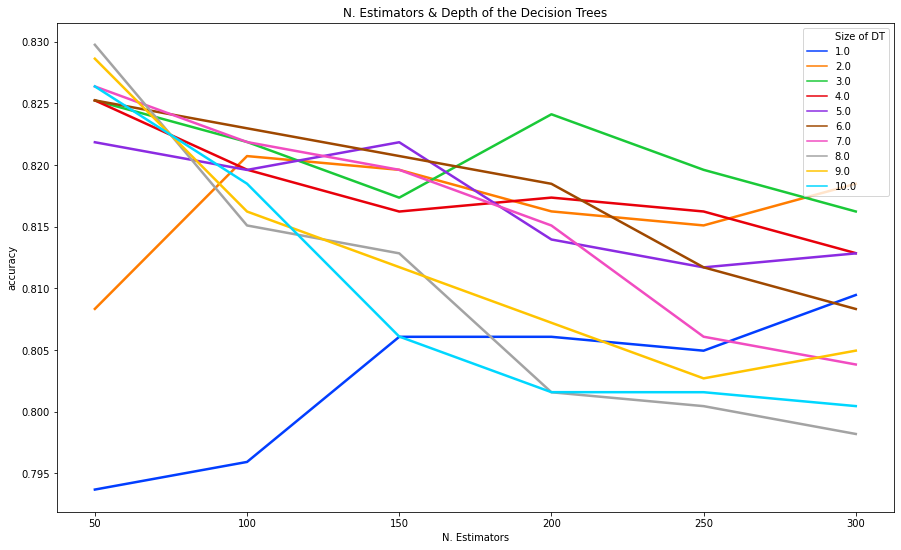

In [16]:
tune(X,y)

In [17]:
# We will use 200 estimators, 3 estimators

# XGBoost
#  evaluated with train & test - remember we have a high variance !  

def run_xg_boost(x, y, estimators, depth):
    
    seed=7
    test_size=0.4

    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)

    # instantied the model
    model=xgb.XGBClassifier(max_depth = depth, n_estimators = estimators)

    # train the model on training data
    model.fit(X_train, y_train)

    # make predictions using test data
    y_predict=model.predict(X_test)

    # evaluate the predictions
    accuracy = accuracy_score(y_test, y_predict)

    print(f'XGBoost - Accuracy {accuracy*100:.3f}%')

In [19]:
# Picked 3 as the maximum depth and 200 minimum trees (higher accuracy with 50 trees, but its too little)

run_xg_boost(X, y, 200, 3)

XGBoost - Accuracy 85.634%


Survived         0.1863
Pclass           0.0639
Age              0.0874
Siblings/Spouses Aboard  0.0102
Parents/Children Aboard  0.0481
Fare             0.6041
[0]	test-logloss:0.675072
Will train until test-logloss hasn't improved in 20 rounds.
[100]	test-logloss:0.468551
[200]	test-logloss:0.419418
[300]	test-logloss:0.406387
Stopping. Best iteration:
[345]	test-logloss:0.403807

Weight. The number of times a feature is used to split the data across all trees.


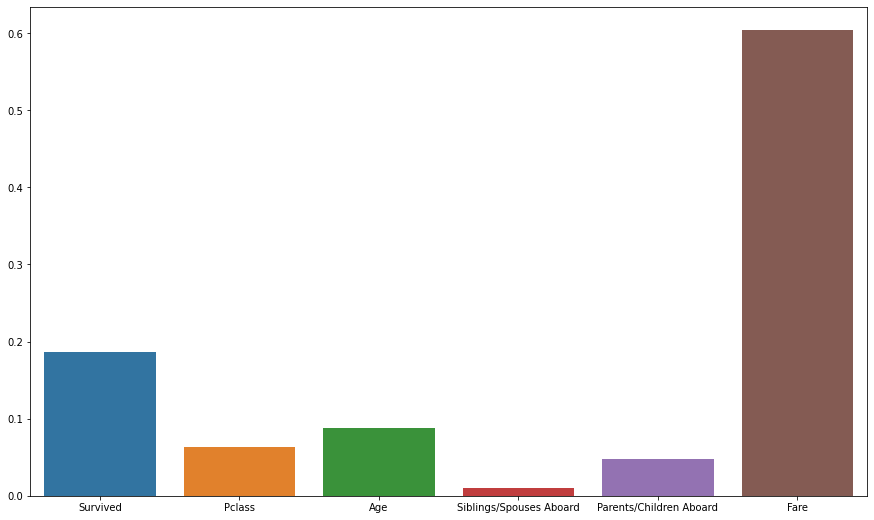

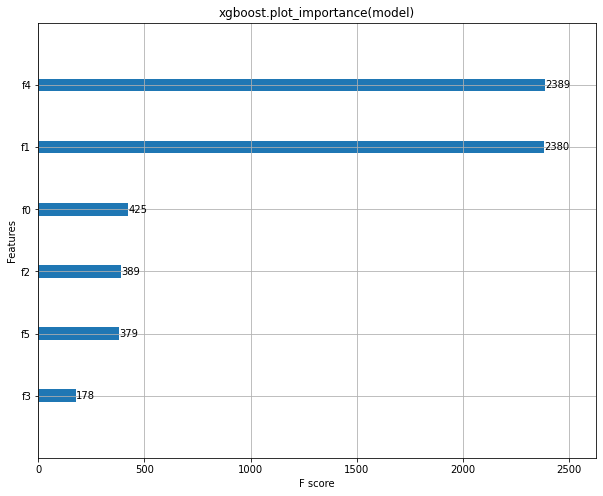

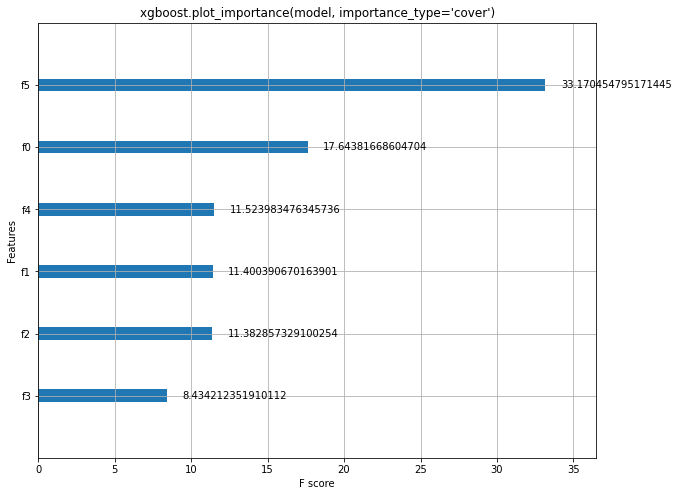

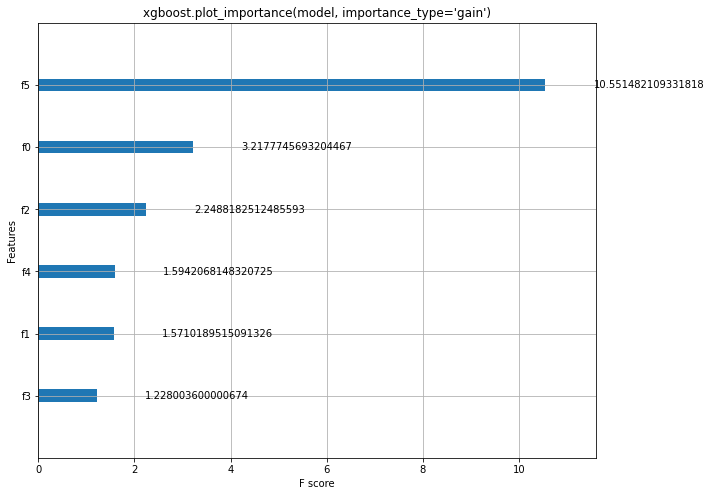

In [23]:
# b) Discuss Feature importance

import numpy as np
import matplotlib.pylab as pl

def feat_imp(x,y):

    # Bar plot

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=7)

    plt.figure(figsize = (15,9))

    seed = 7

    model = XGBClassifier()
    model.fit(X_train,y_train)

    for name, importance in zip(titanic.columns, model.feature_importances_):
        print(f'{name:15s}  {importance:.4f}')

    sns.barplot(x = titanic.columns[:-1], y=model.feature_importances_)

    # Sideways plot
    
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_test = xgb.DMatrix(X_test, label=y_test)

    params = {
        "eta": 0.01,
        "objective": "binary:logistic",
        "subsample": 0.5,
        "base_score": np.mean(y_train),
        "eval_metric": "logloss"
    }
    
    model = xgb.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

    ax = xgb.plot_importance(model, importance_type="weight")
    pl.title("xgboost.plot_importance(model)")

    print(f'Weight. The number of times a feature is used to split the data across all trees.')

    ax.figure.set_size_inches(10,8)

    ax = xgb.plot_importance(model, importance_type="cover")
    pl.title("xgboost.plot_importance(model, importance_type='cover')")

    ax.figure.set_size_inches(10,8)

    ax = xgb.plot_importance(model, importance_type="gain")
    pl.title("xgboost.plot_importance(model, importance_type='gain')")

    ax.figure.set_size_inches(10,8)
    
feat_imp(X,y)